# Libraries

In [1]:
import re
import nltk
import random
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Embedding, LSTM, Dropout, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Dataset

In [3]:
df = pd.read_csv("IMDB Dataset.csv", on_bad_lines = 'skip')
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


# Data Preprocessing

## Label Conversion

In [4]:
df.sentiment = [1 if s == 'positive' else 0 for s in df.sentiment]
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0


## Cleaning Text Data

In [5]:
idx = random.randint(0, len(df) - 1)
before_process = df.iloc[idx][0]
def process(x):
    x = re.sub('[,\.!?:()"]', '', x)
    x = re.sub('<.*?>', ' ', x)
    x = re.sub('http\S+', ' ', x)
    x = re.sub('[^a-zA-Z0-9]', ' ', x)
    x = re.sub('\s+', ' ', x)
    return x.lower().strip()

df['review'] = df['review'].apply(lambda x: process(x))
after_process = df.iloc[idx][0]

## Remove Stopwords

In [6]:
sw_set = set(nltk.corpus.stopwords.words('english'))

def sw_remove(x):
    words = nltk.tokenize.word_tokenize(x)
    filtered_list = [word for word in words if word not in sw_set]
    return ' '.join(filtered_list)

df['review'] = df['review'].apply(lambda x: sw_remove(x))
after_removal = sw_remove(after_process)

## Check the Result

In [7]:
print('\033[1m' + 'Review #%d before preprocessing:'% idx + '\033[0m' + '\n', before_process, '\n')
print('\033[1m' + 'Review #%d after preprocessing:' %idx + '\033[0m' + '\n', after_process, '\n')
print('\033[1m' + 'Review #%d after preprocessing and stopwords removal:' % idx + '\033[0m' + '\n', after_removal)

Review #46149 before preprocessing:
 Holy crap this is so hysterical! Why aren't American comedies written like this? For anybody who thinks comedy has to be dumb-- there is more wit and intelligence in the six episodes of this series than in a shelf of novels! Hugh Laurie is a complete hoot. I couldn't believe it was the same guy as House! There are so many great lines and gags in this series you could watch each show dozens of times and still pick up on new things each time. Rowan Atkinson is hilarious as the verbose and put upon butler Edmund. This is my favorite of all the Blackadder series. And Tony Robinson is wonderful as ever as the somewhat obtuse heart of the series, "the oppressed mass" Baldrick. Some of my favorite lines: "When someone messes with a Wellington he really puts his foot in it" and Baldrick explaining how he got his name and cousin Macadder "the top kipper salesman" and homicidal swordsman from Scotland. 

Review #46149 after preprocessing:
 holy crap this is s

## Data Splitting

In [8]:
train_rev, test_rev, train_sent, test_sent = train_test_split(df['review'], df['sentiment'], test_size = 0.1, random_state = 42)

## Fit Tokenizer

In [9]:
dict_size = 35000
tokenizer = Tokenizer(num_words = dict_size)
tokenizer.fit_on_texts(df['review'])

## Fit Tokenizer to Data Split

In [10]:
train_rev_tokens = tokenizer.texts_to_sequences(train_rev)
test_rev_tokens = tokenizer.texts_to_sequences(test_rev)
seq_lengths = np.array([len(sequence) for sequence in train_rev_tokens])

## Store Upper Bound Sequence

In [11]:
upper_bound = int(np.mean(seq_lengths) + 2 * np.std(seq_lengths))
percentage = stats.percentileofscore(seq_lengths, upper_bound)
percentage

94.55888888888889

## Resize Length Sequence

In [12]:
train_rev_pad = pad_sequences(train_rev_tokens, maxlen = upper_bound)
test_rev_pad = pad_sequences(test_rev_tokens, maxlen = upper_bound)

# LSTM Model

## Define Model

In [13]:
output_dim = 14
units_lstm = 16
r = 0.8

model = Sequential()
model.add(Embedding(input_dim = dict_size, output_dim = output_dim,
                    input_length = upper_bound))
model.add(LSTM(units_lstm))
model.add(Dropout(r))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Compile Model

In [14]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## Model Fit

In [15]:
validation_split = 0.1
batch_size = 384
epochs = 10
fitted = model.fit(train_rev_pad, train_sent, validation_split = validation_split,
                   batch_size = batch_size, epochs = epochs, shuffle = True)

Epoch 1/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 29s 248ms/step - accuracy: 0.5902 - loss: 0.6760 - val_accuracy: 0.8313 - val_loss: 0.4202
Epoch 2/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 42s 263ms/step - accuracy: 0.8578 - loss: 0.3945 - val_accuracy: 0.8898 - val_loss: 0.2826
Epoch 3/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 40s 254ms/step - accuracy: 0.9179 - loss: 0.2658 - val_accuracy: 0.8920 - val_loss: 0.2890
Epoch 4/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 32s 299ms/step - accuracy: 0.9432 - loss: 0.2001 - val_accuracy: 0.8880 - val_loss: 0.2890
Epoch 5/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 35s 240ms/step - accuracy: 0.9542 - loss: 0.1655 - val_accuracy: 0.8880 - val_loss: 0.3015
Epoch 6/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 26s 247ms/step - accuracy: 0.9642 - loss: 0.1386 - val_accuracy: 0.8880 - val_loss: 0.3475
Epoch 7/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 41s 249ms/step - accuracy: 0.9648 - loss: 0.1246 - val_accuracy: 0.8876 - val_loss: 0.3657
Epoch 8/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 26s 247ms/step - accuracy: 0.9707 - loss: 0

## Plotting

Text(0, 0.5, 'Loss')

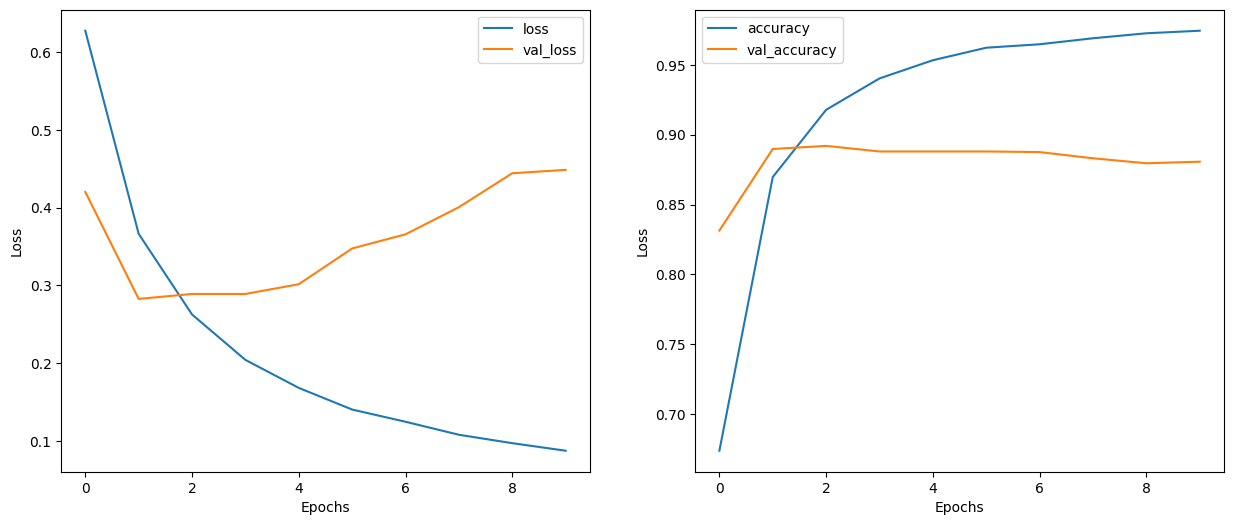

In [16]:
hist_df=pd.DataFrame(fitted.history)
fig, axes = plt.subplots(1, 2, figsize = (15, 6))

# Loss Plot
ax = axes[0]
hist_df.plot(y = ['loss', 'val_loss'], ax = ax)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

# Accuracy Plot
ax1 = axes[1]
hist_df.plot(y = ['accuracy', 'val_accuracy'], ax = ax1)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

## Evaluate Model

In [17]:
result = model.evaluate(test_rev_pad, test_sent)
print(f"Test Loss: {result[0]:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.8785 - loss: 0.4485
Test Loss: 0.4455
Test Accuracy: 0.8802


## Confusion Matrix

In [18]:
predictions = np.round(model.predict(test_rev_pad))
cf_matrix = confusion_matrix(test_sent, predictions)

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step


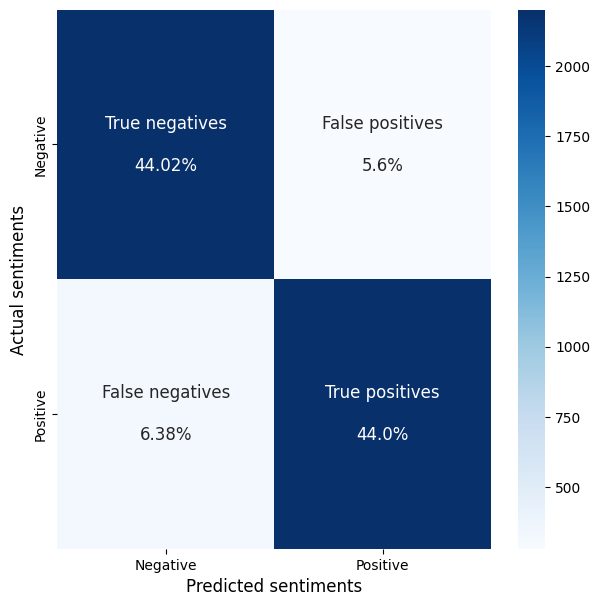

In [19]:
legends = ['True negatives', 'False positives', 'False negatives', 'True positives']
percentages = [round(100 * num, 2) for num in cf_matrix.flatten() / np.sum(cf_matrix)]
labels = [f'{v1}\n\n{v2}%' for v1, v2 in zip(legends, percentages)]
labels = np.asarray(labels).reshape(2, 2)

plt.figure(figsize = (7, 7))

cm = sns.heatmap(cf_matrix, annot = labels, fmt = '', cmap = plt.cm.Blues, annot_kws = {'fontsize': 'large'})
cm.set_xlabel('Predicted sentiments', size = 'large')
cm.set_ylabel('Actual sentiments', size = 'large')
cm.xaxis.set_ticklabels(['Negative', 'Positive'])
cm.yaxis.set_ticklabels(['Negative', 'Positive'])
plt.show()

## Classification Report

In [20]:
print(classification_report(test_sent, predictions))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      2481
           1       0.89      0.87      0.88      2519

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000



## Testing Our Model

In [21]:
df_original = pd.read_csv('movie_review_fix.csv')

idx_test = random.randint(0, len(test_sent) - 1)
idx_original = test_rev.index[idx_test]
(actual_rev, actual_sent) = df_original.iloc[idx_original]

prediction = model.predict(test_rev_pad)[idx_test][0]
prediction_sent = 'positive' if prediction >= 0.5 else 'negative'
probability = round(prediction if prediction >= 0.5 else 1 - prediction, 2)

print('\033[1m' + 'Review #%d:' % idx_original + '\033[0m' + '\n', actual_rev, '\n')
print('\033[1m' + 'Predicted sentiment:' + '\033[0m', prediction_sent, '(with probability %.2f)' % probability, '\n')
print('\033[1m' + 'Actual sentiment:' + '\033[0m', actual_sent)

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step
Review #5653:
 the film also moves fast ( a mere 95 minutes ) , develops a certain " cute " chemistry between fonda and li , has nice surroundings ( paris , baby ! ) and gives us one of the best bad guys that i've seen all year . 

Predicted sentiment: positive (with probability 0.90) 

Actual sentiment: positive


# Best LSTM Model

## Define Model

In [22]:
output_dim = 14
units_lstm = 16
r = 0.4

model = Sequential()
model.add(Embedding(input_dim = dict_size, output_dim = output_dim))
model.add(LSTM(units_lstm))
model.add(Dropout(r))
model.add(Dense(1, activation = 'sigmoid'))

# Build model with input shape
model.build(input_shape = (None, upper_bound))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 291, 14)             │         490,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 16)                  │           1,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 492,001 (1.88 MB)

 Trainable params: 492,001 (1.88 MB)

 Non-trainable params: 0 (0.00 B)

## Compile Model

In [23]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adamax', metrics = ['accuracy'])
validation_split = 0.1
batch_size = 400
epochs = 20

## Model Fit

In [24]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)

fitted = model.fit(train_rev_pad, train_sent, validation_split = validation_split,
                   batch_size = batch_size, epochs = epochs, shuffle = True, callbacks = [early_stopping])

Epoch 1/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 28s 247ms/step - accuracy: 0.5428 - loss: 0.6924 - val_accuracy: 0.7056 - val_loss: 0.6857
Epoch 2/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 25s 248ms/step - accuracy: 0.7447 - loss: 0.6620 - val_accuracy: 0.8442 - val_loss: 0.4871
Epoch 3/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 43s 265ms/step - accuracy: 0.8493 - loss: 0.4542 - val_accuracy: 0.8651 - val_loss: 0.3866
Epoch 4/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 38s 240ms/step - accuracy: 0.8866 - loss: 0.3597 - val_accuracy: 0.8778 - val_loss: 0.3447
Epoch 5/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 42s 254ms/step - accuracy: 0.9026 - loss: 0.3115 - val_accuracy: 0.8816 - val_loss: 0.3243
Epoch 6/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 39s 236ms/step - accuracy: 0.9142 - loss: 0.2770 - val_accuracy: 0.8898 - val_loss: 0.3006
Epoch 7/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 41s 236ms/step - accuracy: 0.9230 - loss: 0.2516 - val_accuracy: 0.8904 - val_loss: 0.2933
Epoch 8/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 41s 238ms/step - accuracy: 0.9289 - loss: 0

## Plotting

Text(0, 0.5, 'Loss')

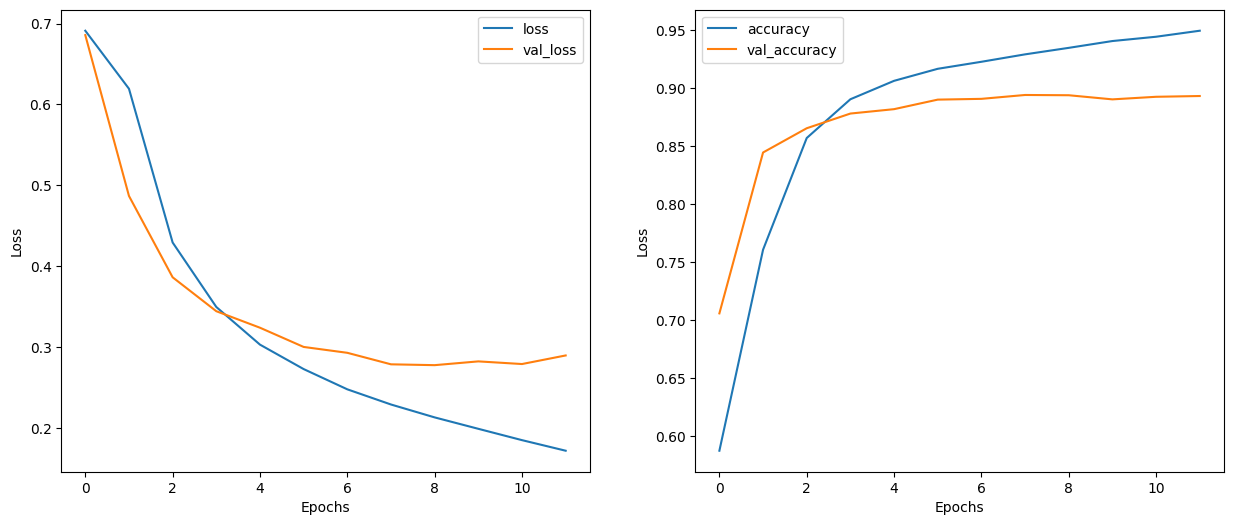

In [25]:
hist_df=pd.DataFrame(fitted.history)
fig, axes = plt.subplots(1, 2, figsize = (15, 6))

# Loss Pot
ax = axes[0]
hist_df.plot(y = ['loss', 'val_loss'], ax = ax)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

# Accuracy Plot
ax1 = axes[1]
hist_df.plot(y = ['accuracy', 'val_accuracy'], ax = ax1)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

## Evaluate Model

In [26]:
result = model.evaluate(test_rev_pad, test_sent)
print(f"Test Loss: {result[0]:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.8979 - loss: 0.2714
Test Loss: 0.2738
Test Accuracy: 0.8998


## Confusion Matrix

In [27]:
predictions = np.round(model.predict(test_rev_pad))
cf_matrix = confusion_matrix(test_sent, predictions)

157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step


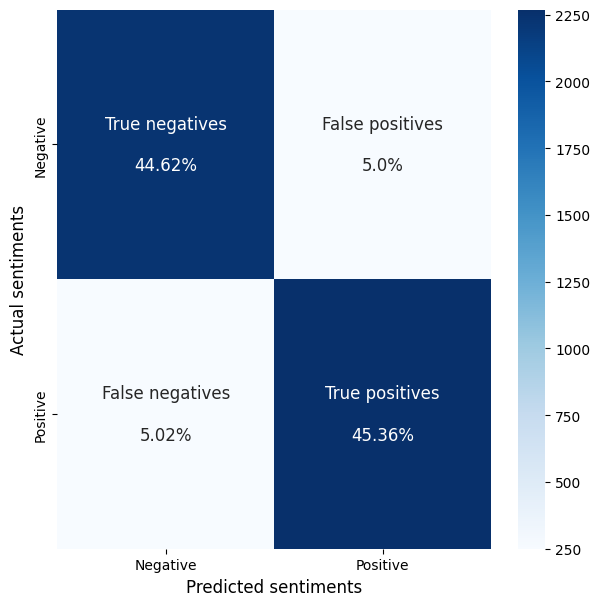

In [28]:
legends = ['True negatives', 'False positives', 'False negatives', 'True positives']
percentages = [round(100 * num, 2) for num in cf_matrix.flatten() / np.sum(cf_matrix)]
labels = [f'{v1}\n\n{v2}%' for v1, v2 in zip(legends, percentages)]
labels = np.asarray(labels).reshape(2, 2)

plt.figure(figsize = (7, 7))

cm = sns.heatmap(cf_matrix, annot = labels, fmt = '', cmap = plt.cm.Blues, annot_kws = {'fontsize': 'large'})
cm.set_xlabel('Predicted sentiments', size = 'large')
cm.set_ylabel('Actual sentiments', size = 'large')
cm.xaxis.set_ticklabels(['Negative', 'Positive'])
cm.yaxis.set_ticklabels(['Negative', 'Positive'])
plt.show()

## Classification Report

In [29]:
print(classification_report(test_sent, predictions))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      2481
           1       0.90      0.90      0.90      2519

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000



## Testing Our Model

In [35]:
df_original = pd.read_csv('movie_review_fix.csv')

idx_test = random.randint(0, len(test_sent) - 1)
idx_original = test_rev.index[idx_test]
(actual_rev, actual_sent) = df_original.iloc[idx_original]

prediction = model.predict(test_rev_pad)[idx_test][0]
prediction_sent = 'positive' if prediction >= 0.5 else 'negative'
probability = round(prediction if prediction >= 0.5 else 1 - prediction, 2)

print('\033[1m' + 'Review #%d:' % idx_original + '\033[0m' + '\n', actual_rev, '\n')
print('\033[1m' + 'Predicted sentiment:' + '\033[0m', prediction_sent, '(with probability %.2f)' % probability, '\n')
print('\033[1m' + 'Actual sentiment:' + '\033[0m', actual_sent)

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step
Review #31469:
 " shine " has just scooped the pool at the australian film institute awards , picking up best film , best actor , best director etc . to that we can add the gritty " life " ( the anguish , courage and friendship of a group of male prisoners in the hiv-positiveitive section of a jail ) and " love and other catastrophes " ( a low budget gem about straight and gay love on and near a university campus ) . 

Predicted sentiment: positive (with probability 0.79) 

Actual sentiment: positive


# RNN Model

## Data Preprocessing

In [46]:
train_rev, test_rev, train_sent, test_sent = train_test_split(df['review'],
                                                              df['sentiment'],
                                                              test_size = 0.1,
                                                              random_state = 42)
dict_size = 35000
tokenizer = Tokenizer(num_words = dict_size)
tokenizer.fit_on_texts(df['review'])

train_rev_tokens = tokenizer.texts_to_sequences(train_rev)
test_rev_tokens = tokenizer.texts_to_sequences(test_rev)
seq_lengths = np.array([len(sequence) for sequence in train_rev_tokens])

upper_bound = int(np.mean(seq_lengths) + 2 * np.std(seq_lengths))
percentage = stats.percentileofscore(seq_lengths, upper_bound)

train_rev_pad = pad_sequences(train_rev_tokens, maxlen = upper_bound)
test_rev_pad = pad_sequences(test_rev_tokens, maxlen = upper_bound)

## Model Parameters

In [47]:
output_dim = 14
units_rnn = 16
r = 0.4

## Define Model

In [48]:
model = Sequential()
model.add(Embedding(input_dim = dict_size, output_dim = output_dim))
model.add(SimpleRNN(units_rnn))
model.add(Dropout(r))
model.add(Dense(1, activation = 'sigmoid'))

## Compile Model

In [49]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adamax', metrics = ['accuracy'])
validation_split = 0.1
batch_size = 400
epochs = 20

## Model Fit

In [50]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)

fitted = model.fit(train_rev_pad, train_sent, validation_split = validation_split,
                   batch_size = batch_size, epochs = epochs, shuffle = True, callbacks = [early_stopping])

Epoch 1/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 15s 131ms/step - accuracy: 0.5176 - loss: 0.6950 - val_accuracy: 0.6307 - val_loss: 0.6609
Epoch 2/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step - accuracy: 0.6676 - loss: 0.6257 - val_accuracy: 0.7764 - val_loss: 0.5295
Epoch 3/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 21s 128ms/step - accuracy: 0.7977 - loss: 0.5027 - val_accuracy: 0.8227 - val_loss: 0.4450
Epoch 4/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.8356 - loss: 0.4340 - val_accuracy: 0.8267 - val_loss: 0.4118
Epoch 5/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - accuracy: 0.8571 - loss: 0.3856 - val_accuracy: 0.8393 - val_loss: 0.3811
Epoch 6/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - accuracy: 0.8813 - loss: 0.3412 - val_accuracy: 0.8444 - val_loss: 0.3640
Epoch 7/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - accuracy: 0.8921 - loss: 0.3144 - val_accuracy: 0.8496 - val_loss: 0.3527
Epoch 8/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9066 - loss: 0

## Plotting

Text(0, 0.5, 'Accuracy')

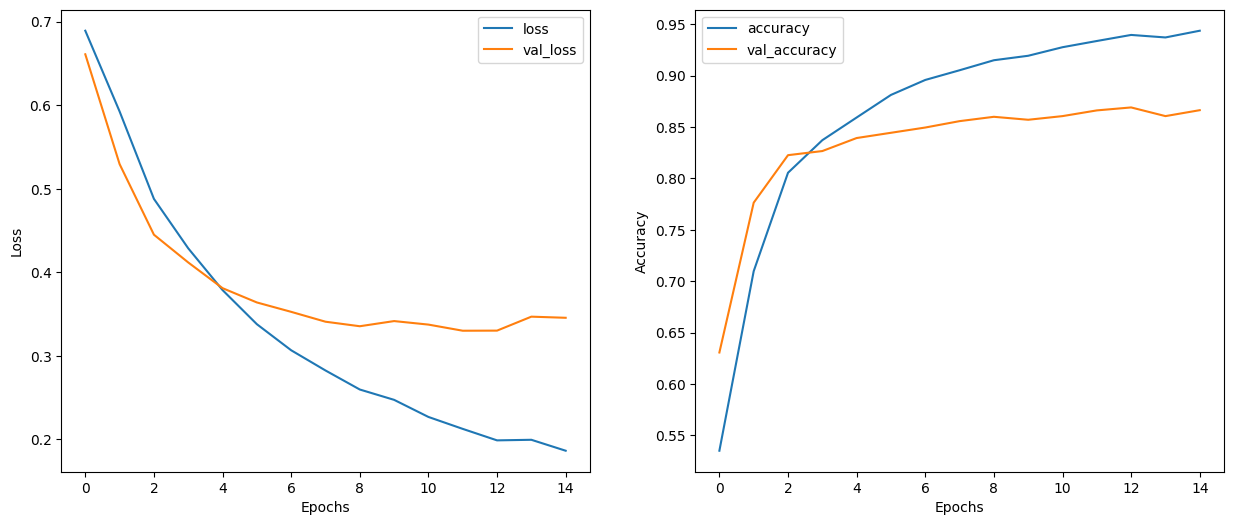

In [51]:
hist_df = pd.DataFrame(fitted.history)
fig, axes = plt.subplots(1, 2, figsize = (15, 6))

# Loss plot
ax = axes[0]
hist_df.plot(y=['loss', 'val_loss'], ax=ax)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

# Accuracy plot
ax1 = axes[1]
hist_df.plot(y=['accuracy', 'val_accuracy'], ax=ax1)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")

## Evaluate Model

In [52]:
result = model.evaluate(test_rev_pad, test_sent)
print(f"Test Loss: {result[0]:.4f}")
print(f"Test Accuracy: {result[1]:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8632 - loss: 0.3328
Test Loss: 0.3326
Test Accuracy: 0.8644


## Confusion Matrix

In [53]:
predictions = np.round(model.predict(test_rev_pad))
cf_matrix = confusion_matrix(test_sent, predictions)

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step


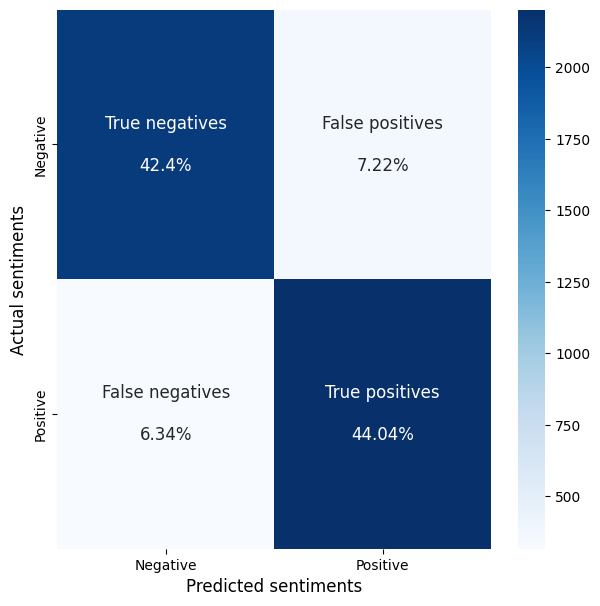

In [54]:
legends = ['True negatives', 'False positives', 'False negatives', 'True positives']
percentages = [round(100 * num, 2) for num in cf_matrix.flatten() / np.sum(cf_matrix)]
labels = [f'{v1}\n\n{v2}%' for v1, v2 in zip(legends, percentages)]
labels = np.asarray(labels).reshape(2, 2)

plt.figure(figsize=(7, 7))
cm = sns.heatmap(cf_matrix, annot=labels, fmt = '', cmap = plt.cm.Blues, annot_kws = {'fontsize': 'large'})
cm.set_xlabel('Predicted sentiments', size = 'large')
cm.set_ylabel('Actual sentiments', size = 'large')
cm.xaxis.set_ticklabels(['Negative', 'Positive'])
cm.yaxis.set_ticklabels(['Negative', 'Positive'])
plt.show()

## Classification Report

In [55]:
print(classification_report(test_sent, predictions))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      2481
           1       0.86      0.87      0.87      2519

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000



## Testing Our Model

In [57]:
df_original = pd.read_csv('movie_review_fix.csv')

idx_test = random.randint(0, len(test_sent) - 1)
idx_original = test_rev.index[idx_test]
(actual_rev, actual_sent) = df_original.iloc[idx_original]

prediction = model.predict(test_rev_pad)[idx_test][0]
prediction_sent = 'positive' if prediction >= 0.5 else 'negative'
probability = round(prediction if prediction >= 0.5 else 1 - prediction, 2)

print('\033[1m' + 'Review #%d:' % idx_original + '\033[0m' + '\n', actual_rev, '\n')
print('\033[1m' + 'Predicted sentiment:' + '\033[0m', prediction_sent, '(with probability %.2f)' % probability, '\n')
print('\033[1m' + 'Actual sentiment:' + '\033[0m', actual_sent)

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
Review #31680:
 this begins the trademarked coen brothers crimes-gone-wrong sequences . 

Predicted sentiment: positive (with probability 0.95) 

Actual sentiment: positive
